## Load Data

In [23]:
import pandas as pd
import numpy as np
import pickle
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [24]:
base_path = r"D:\Datasets\WESAD\WESAD"
subject_id = "S2" # Change subject ID as needed
file_path = os.path.join(base_path, subject_id, f"{subject_id}.pkl")

TARGET_RATE = 700  
WINDOW_SECONDS = 2     
BATCH_SIZE = 16

In [25]:
def load_and_process_data(file_path, target_rate):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found at {file_path}")
        
    print(f"Loading {file_path}...")
    with open(file_path, 'rb') as file:
        data = pickle.load(file, encoding='latin1')

    # 1. Extract Chest Data
    chest_data = data['signal']['chest']
    df = pd.DataFrame()
    df['ACC_x'] = chest_data['ACC'][:, 0]
    df['ACC_y'] = chest_data['ACC'][:, 1]
    df['ACC_z'] = chest_data['ACC'][:, 2]
    df['ECG']   = chest_data['ECG'].flatten()
    df['EMG']   = chest_data['EMG'].flatten()
    df['EDA']   = chest_data['EDA'].flatten()
    df['Temp']  = chest_data['Temp'].flatten()
    df['Resp']  = chest_data['Resp'].flatten()
    df['label'] = data['label']

    # 2. Filter Labels (1=Baseline, 2=Stress)
    df = df[df['label'].isin([1, 2])].copy()
    
    # 3. Remap Labels (1->0, 2->1)
    df['label'] = df['label'].map({1: 0, 2: 1})
    

    return df

def create_non_overlapping_windows(df, window_seconds, rate):
    """
    Creates windows with NO OVERLAP (Stride = Window Size).
    This allows us to shuffle data without leakage.
    """
    window_steps = window_seconds * rate
    stride_steps = window_seconds * rate # Key: Stride = Window
    
    data_np = df.drop(columns=['label'], errors='ignore').values
    labels_np = df['label'].values
    
    X_list = []
    y_list = []
    
    for i in range(0, len(df) - window_steps, stride_steps):
        w_data = data_np[i : i + window_steps]
        # Label is the mode (most frequent) of the window
        w_label = stats.mode(labels_np[i : i + window_steps], keepdims=True)[0][0]
        
        X_list.append(w_data.transpose())
        y_list.append(w_label)
        
    return np.array(X_list), np.array(y_list)

In [26]:
# 1. Load
df = load_and_process_data(file_path, TARGET_RATE)

# 2. Windowing (Non-Overlapping)
print("Creating windows...")
X, y = create_non_overlapping_windows(df, WINDOW_SECONDS, TARGET_RATE)
print(f"Window Shape: {X.shape} (Samples, Channels, TimeSteps)")

# --- THE FIX: Window-Wise Normalization ---
# We calculate Mean and Std for EACH window separately (axis=2 is time)
epsilon = 1e-6  # Prevent division by zero
means = X.mean(axis=2, keepdims=True)
stds  = X.std(axis=2, keepdims=True)

# Normalize: (Value - WindowMean) / WindowStd
X_norm = (X - means) / (stds + epsilon)

# Force float32
X_scaled = X_norm.astype(np.float32)

print(f"Window-Wise Normalized. Global Mean: {X_scaled.mean():.2f}, Std: {X_scaled.std():.2f}")
print("Now the model must learn signal morphology, so noise will break it.")

# 4. Split (Random Shuffle is SAFE now)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y, shuffle=True
)

# 5. Create DataLoaders
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train).long())
test_ds = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test).long())

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train Samples: {len(X_train)} | Test Samples: {len(X_test)}")

Loading D:\Datasets\WESAD\WESAD\S2\S2.pkl...
Creating windows...
Window Shape: (879, 8, 1400) (Samples, Channels, TimeSteps)
Creating windows...
Window Shape: (879, 8, 1400) (Samples, Channels, TimeSteps)
Window-Wise Normalized. Global Mean: -0.00, Std: 1.00
Now the model must learn signal morphology, so noise will break it.
Train Samples: 703 | Test Samples: 176
Window-Wise Normalized. Global Mean: -0.00, Std: 1.00
Now the model must learn signal morphology, so noise will break it.
Train Samples: 703 | Test Samples: 176


In [27]:
class WideScaleModel(nn.Module):
    def __init__(self, input_channels=8, num_classes=2, window_size=1400):
        super(WideScaleModel, self).__init__()
        
        self.encoder = nn.Sequential(
            # Layer 1: Wide Kernel (15) to see trends
            nn.Conv1d(input_channels, 32, kernel_size=15, padding=7),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),  # 1400 -> 700
            nn.Dropout(0.2),
            
            # Layer 2: Finer details
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),  # 700 -> 350
            nn.Dropout(0.2)
        )
        
        # Flatten size calculation: window_size -> /2 -> /2
        final_timesteps = window_size // 4  # 1400 -> 350
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * final_timesteps, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.encoder(x))

# Calculate window size from your config
window_size = WINDOW_SECONDS * TARGET_RATE  # 2 * 700 = 1400

model = WideScaleModel(window_size=window_size).to(device)
print(f"Model Initialized for window size: {window_size}")

Model Initialized for window size: 1400


In [28]:
# 1. Calculate Class Weights (Fixes Imbalance)
n0 = (y_train == 0).sum()
n1 = (y_train == 1).sum()
weight_ratio = n0 / n1
weights = torch.tensor([1.0, weight_ratio], dtype=torch.float32).to(device)  # Explicit float32
print(f"Using Class Weights: {weights}")

# 2. Optimizer & Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=weights)

# 3. Train
print("Starting Training...")
for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print(f"Epoch {epoch+1} | Loss: {running_loss/len(train_loader):.4f} | Train Acc: {100*correct/total:.2f}%")

print("Training Complete.")

Using Class Weights: tensor([1.0000, 1.8577])
Starting Training...
Epoch 1 | Loss: 1.1145 | Train Acc: 48.65%
Epoch 1 | Loss: 1.1145 | Train Acc: 48.65%
Epoch 2 | Loss: 0.6445 | Train Acc: 62.02%
Epoch 2 | Loss: 0.6445 | Train Acc: 62.02%
Epoch 3 | Loss: 0.4533 | Train Acc: 75.25%
Epoch 3 | Loss: 0.4533 | Train Acc: 75.25%
Epoch 4 | Loss: 0.3571 | Train Acc: 75.25%
Epoch 4 | Loss: 0.3571 | Train Acc: 75.25%
Epoch 5 | Loss: 0.3130 | Train Acc: 81.08%
Epoch 5 | Loss: 0.3130 | Train Acc: 81.08%
Epoch 6 | Loss: 0.2819 | Train Acc: 78.81%
Epoch 6 | Loss: 0.2819 | Train Acc: 78.81%
Epoch 7 | Loss: 0.2592 | Train Acc: 78.95%
Epoch 7 | Loss: 0.2592 | Train Acc: 78.95%
Epoch 8 | Loss: 0.1952 | Train Acc: 83.07%
Epoch 8 | Loss: 0.1952 | Train Acc: 83.07%
Epoch 9 | Loss: 0.2014 | Train Acc: 82.65%
Epoch 9 | Loss: 0.2014 | Train Acc: 82.65%
Epoch 10 | Loss: 0.1924 | Train Acc: 83.64%
Training Complete.
Epoch 10 | Loss: 0.1924 | Train Acc: 83.64%
Training Complete.


--- Classification Report ---
              precision    recall  f1-score   support

    Baseline       1.00      0.93      0.96       115
      Stress       0.88      1.00      0.94        61

    accuracy                           0.95       176
   macro avg       0.94      0.97      0.95       176
weighted avg       0.96      0.95      0.96       176



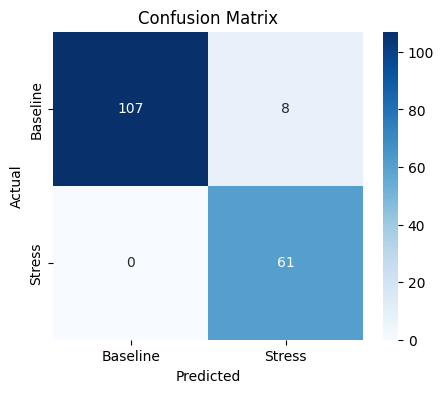

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model_performance(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    # Print Report
    print("--- Classification Report ---")
    print(classification_report(all_labels, all_preds, target_names=['Baseline', 'Stress']))
    
    # Plot Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Baseline', 'Stress'], yticklabels=['Baseline', 'Stress'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Run the diagnosis
evaluate_model_performance(model, test_loader)

In [30]:
def attack_test(model, loader, noise_level):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Add Noise (Attack)
            noise = torch.randn_like(inputs) * noise_level
            attacked_inputs = inputs + noise
            
            outputs = model(attacked_inputs)
            _, preds = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            
    return 100 * correct / total

print("\n--- INTRUSION RESILIENCE RESULTS ---")
print("1. Clean Accuracy (Should be >90%):")
print(f"   {attack_test(model, test_loader, 0.0):.2f}%")

print("2. Attack Accuracy (Should be <50% to prove vulnerability):")
print(f"{attack_test(model, test_loader, 3):.2f}%")


--- INTRUSION RESILIENCE RESULTS ---
1. Clean Accuracy (Should be >90%):
   95.45%
2. Attack Accuracy (Should be <50% to prove vulnerability):
65.91%
65.91%


In [31]:
print(f"Max Value in Data: {X_scaled.max()}")
print(f"Min Value in Data: {X_scaled.min()}")
print(f"Mean Value in Data: {X_scaled.mean()}")


Max Value in Data: 12.715822219848633
Min Value in Data: -18.70511817932129
Mean Value in Data: -4.657551566644713e-10
